In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [55]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
#chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}
use_polynomial = False
if use_polynomial:
    energy_func = lambda x : phase.polynomial_energy(x)
else:
    energy_func = lambda x : phase.flory_huggins(x,configuration['M'],
                                                 configuration['chi'],beta=0.0)

energy_func = lambda x : phase.flory_huggins(x, [1626, 12.4, 1],[0.44,1.48,1.9], beta=0.0)

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': True, 
    'pad_energy': 2,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }
out = phase.serialcompute(energy_func, 3,meshsize, **kwargs) 


3-dimensional grid generated at 0.04s
Energy computed at 0.39s
Making energy manifold a paraboloid with 2x padding of 0.12 maximum energy
Energy is corrected at 0.63s
Convexhull is computed at 0.63s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 23 simplices in the convex hull
Simplices are labelled at 0.65s
Labels are lifted at 0.67s
Total 0/23 coplanar simplices
Computation took 0.67s


<IPython.core.display.Javascript object>


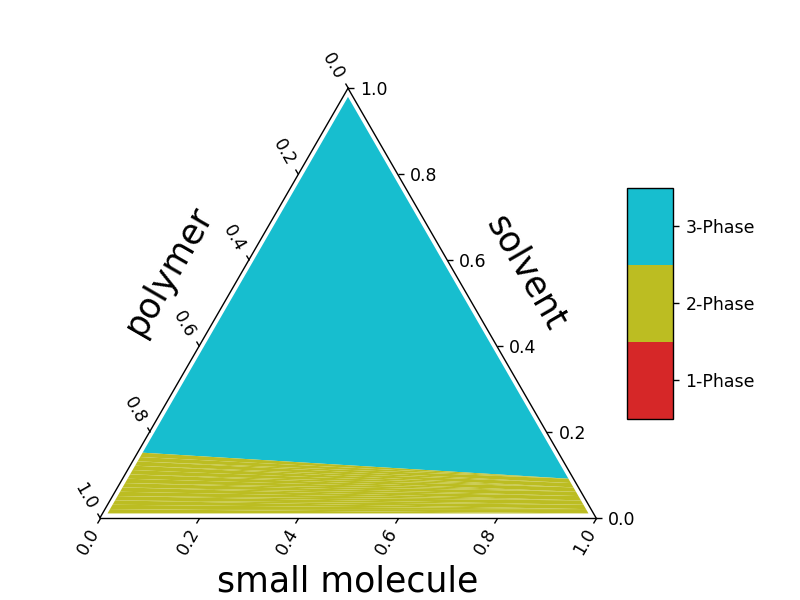

In [56]:
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']

# phase.plot_lifted_label_ternary(out['output'])
phase.plot_mpltern(grid, simplices, num_comps)
plt.show()

<IPython.core.display.Javascript object>


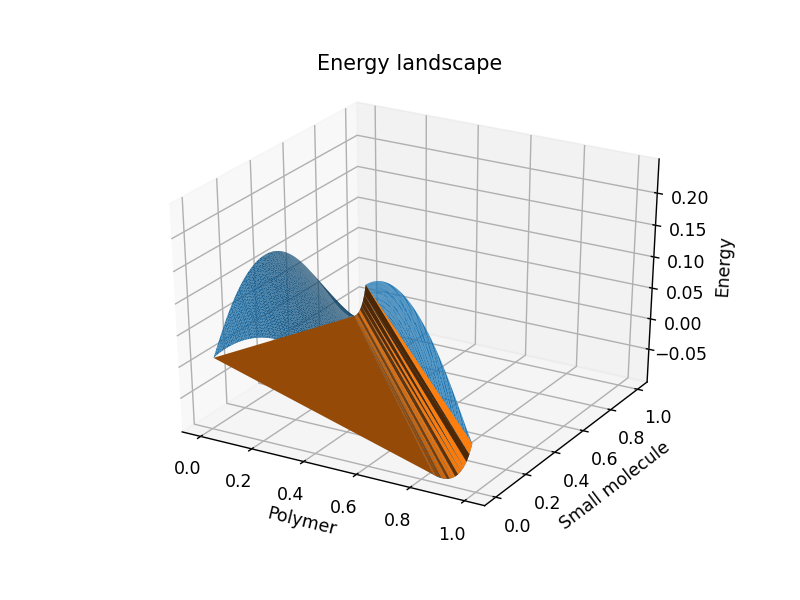

In [57]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
phase.plot_energy_landscape(out, mode='full', ax = ax)
phase.plot_energy_landscape(out, mode='convex_hull', ax = ax)
plt.show()

<IPython.core.display.Javascript object>


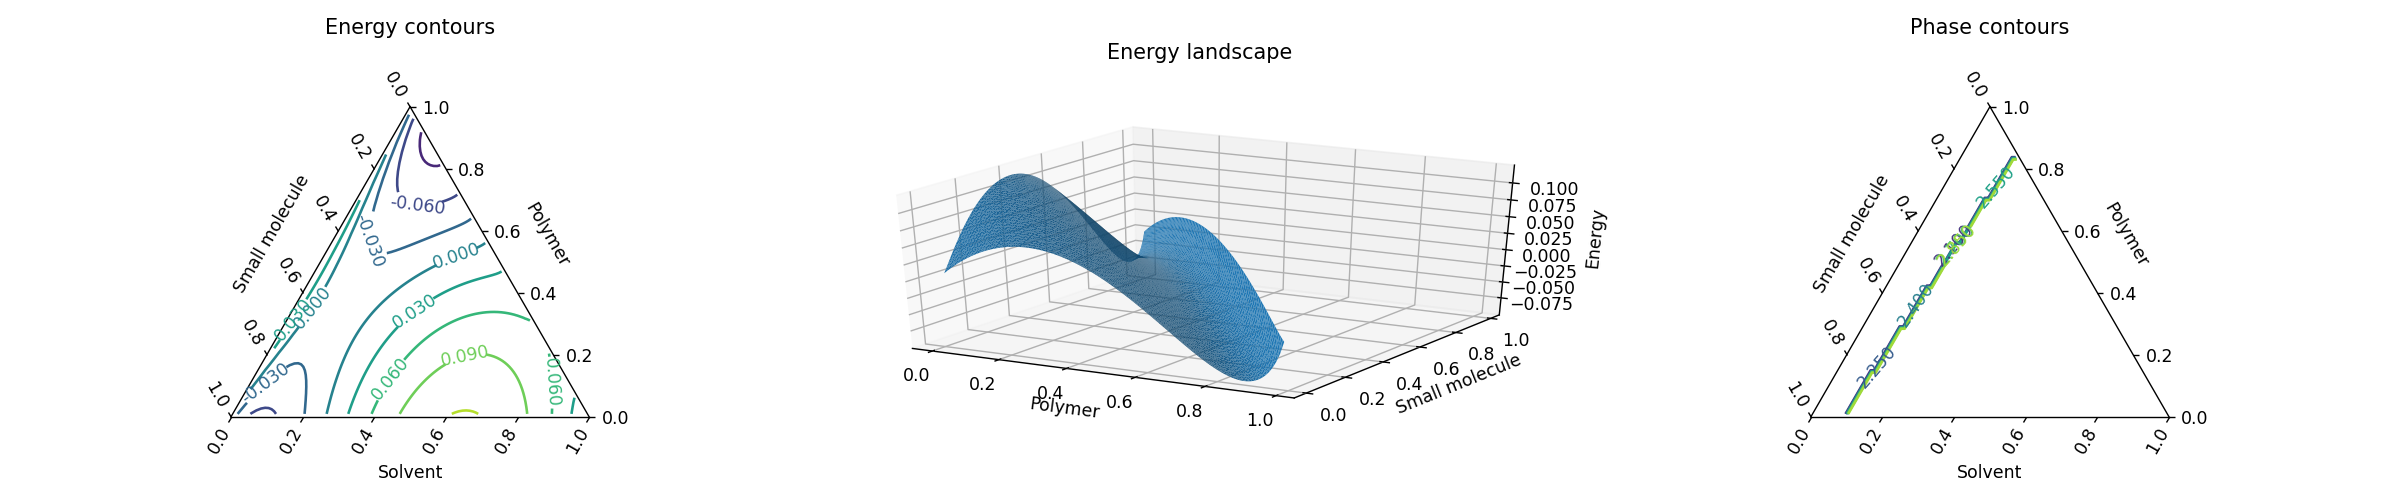

In [58]:
def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*4*1.6,4))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

labels = out['output'].loc['label',:].to_numpy()
boundary_points= np.asarray([phase.is_boundary_point(x) for x in grid.T])
plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], labels[~boundary_points])
#plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
plt.show()

In [59]:
CHI = phase._utri2mat(configuration['chi'],3)
def threecomp_gradphi_FH(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1] + beta*((1/x[2]**2) - (1/x[0]**2))
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]+ beta*((1/x[2]**2) - (1/x[1]**2))
    
    return [dEdx1, dEdx2]

def _grad_polynomial(x):
    
    grad = 2*(x-0.1)*(0.9-x)*(1-2*x)
    
    return grad*1e3

def polynomial_gradient(x,**kwargs):
    grad = []
    df_dx3 = 2*1e3*(0.9-x[0]-x[1])*(x[0]+x[1]-0.1)*(1-2*x[0]-2*x[1])
    for xi in x[:2]:
        df_dxi = _grad_polynomial(xi)
        grad.append(df_dxi + df_dx3)
        
    return grad

if use_polynomial:
    analytic_gradient = lambda phi : polynomial_gradient(phi)
else:
    analytic_gradient = lambda phi : threecomp_gradphi_FH(phi)

In [60]:
import matplotlib.tri as mtri

class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    change the energy formulation
    """
    def __init__(self, grid, energy):
        if callable(energy):
            self.func = energy
        else:
            triang = mtri.Triangulation(grid[0,:], grid[1,:])
            self.interp_lin = mtri.LinearTriInterpolator(triang, energy)

    def __call__(self,phi, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        p1,p2,p3 = phi
        f_right = self.func([p1+h,p2,1-p1-h-p2])
        f_left = self.func([p1-h,p2,1-p1+h-p2])
        df_dx = (f_right - f_left)/(2*h)
        
        f_right = self.func([p1,p2+h,1-p1-h-p2])
        f_left = self.func([p1,p2-h,1-p1+h-p2])
        df_dy = (f_right - f_left)/(2*h)
        
        return [df_dx, df_dy]
    
    def plot_interpolated_energy(self):
        xi, yi = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
        z = self.func(xi, yi)
        fig, ax = plt.subplots()
        ax.contourf(xi, yi, z)
        plt.show()

delta = np.linalg.norm(grid[:2,0] - grid[:2,1])   
centraldiff_gradient = CentralDifference(grid, energy_func)    
grad_cd = np.asarray([centraldiff_gradient(phi, h = delta) for phi in grid.T])

/projects/academic/olgawodo/kiranvad/Projects/Spring2020/PhaseModelling/polyphase/utils.py:31: RuntimeWarning: invalid value encountered in log
  T1 += (xi*np.log(xi))/M[i] + beta/xi


In [68]:
test = phase.TestAngles(out,phase=3,**kwargs)

Angle at vertex 0 is 161.37 degrees
Angle at vertex 1 is 175.47 degrees
Angle at vertex 2 is 136.23 degrees


<IPython.core.display.Javascript object>


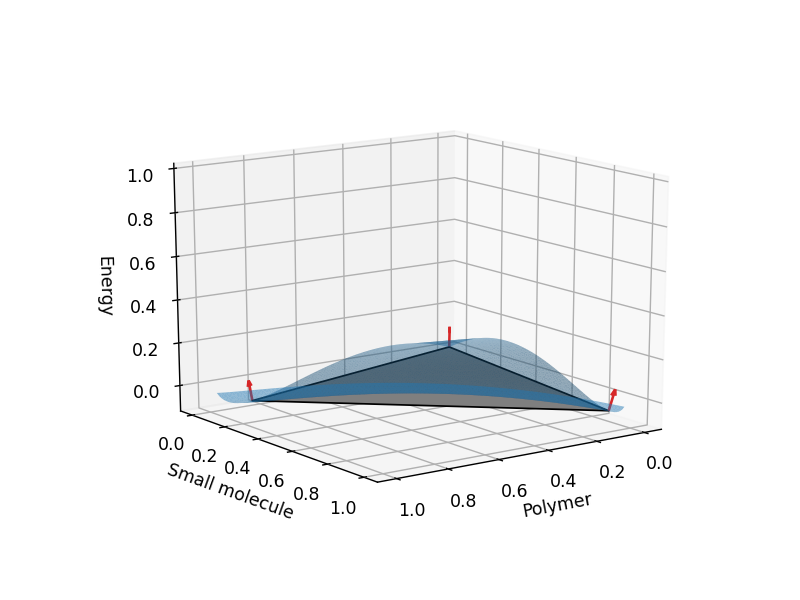

<IPython.core.display.Javascript object>


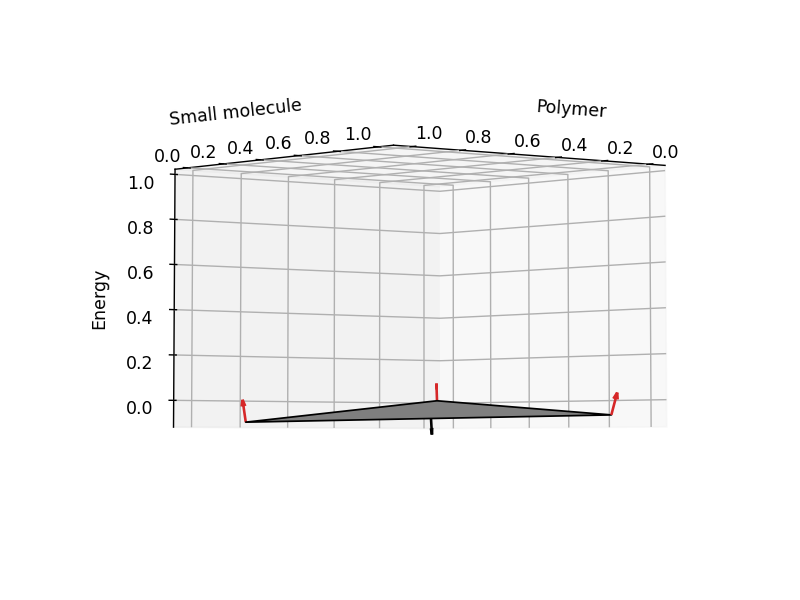

In [72]:
test_out = test.get_angles(centraldiff_gradient)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))

fig,ax = test.visualize(required=[1,2])
plt.show()
fig,ax = test.visualize(required=[2])
plt.show()

In [63]:
# get all angles of all 2-phase simplices
phase_simplices_ids = np.where(np.asarray(num_comps)==2)[0]
angles_list = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(out,phase=2,simplex_id=simplex_id,**kwargs)
    test_out = test.get_angles(centraldiff_gradient)
    for _, value in test_out['thetas'].items():
        theta = value[2]
        if theta<160:
            print(simplex_id, theta )
        angles_list.append(theta)
        
assert len(angles_list)==len(phase_simplices_ids)*3    

2 159.277183938116
5 159.28693468672702
7 159.95187306014878
8 159.39640782068233


<IPython.core.display.Javascript object>


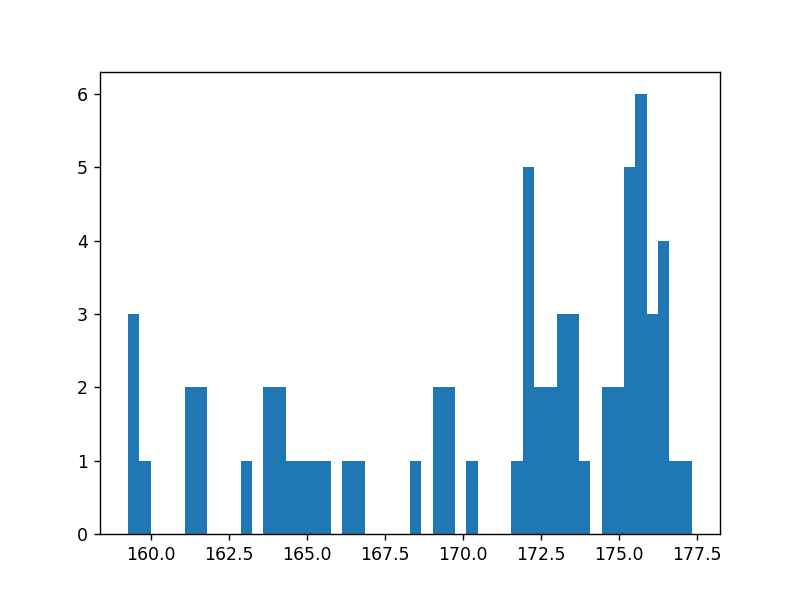

In [64]:
import seaborn as sns
fig, ax = plt.subplots()
ax.hist(angles_list,bins=50, density=False)
plt.show()

<IPython.core.display.Javascript object>


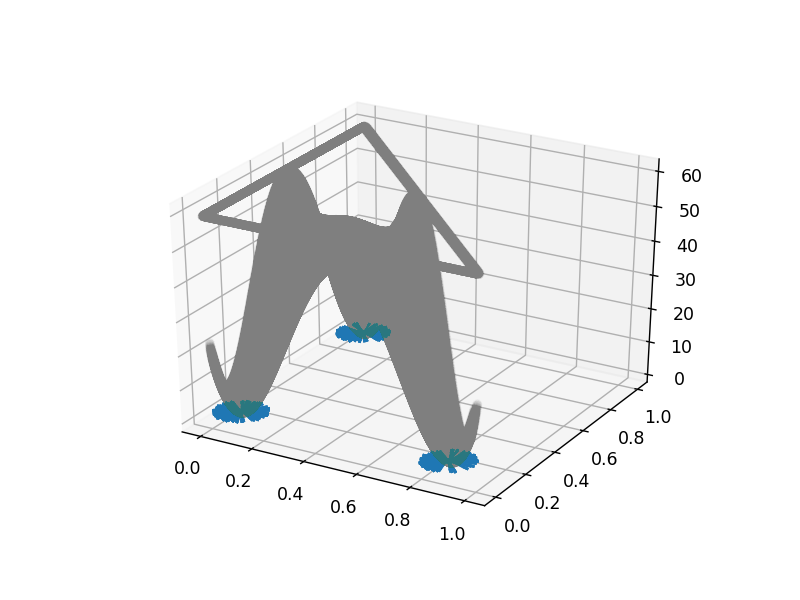

Vertex : [0.07017544789473683, 0.8646616554887218, 1.8535035371476491]


Vertex : [0.8646616554887218, 0.07017544789473683, 1.8535035371476491]


Vertex : [0.07268171353383457, 0.07017544789473683, 1.853503537147649]




/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
"""
Each vertex here is a parametric point with phi1, phi2, energy
For any vertex, the first neighbor is the point itself thus this would be angle reported in the figure above
"""

from sklearn.neighbors import NearestNeighbors
samples = np.vstack((grid[:2,:],energy.reshape(1,-1))).T
neigh = NearestNeighbors(n_neighbors=100)
neigh.fit(samples)
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

for tpp in test.parametric_points:
    print('Vertex : {}'.format(tpp))
    vertex = np.asarray(tpp)
    neigh_dist, neigh_ind = neigh.kneighbors(vertex.reshape(1,-1))
    neighbors = samples[neigh_ind,:].squeeze()
    angles = []
    normals = []
    for i in neighbors:
        grad = centraldiff_gradient(i, h = delta)
        normal,_,_ = test._get_normal(i, centraldiff_gradient)
        angle = test._angle_between_vectors(test.facet_normal, normal)
        angles.append(angle)
        normals.append(normal)
    print('\n')
    angles = np.asarray(angles)
    normals = np.asarray(normals)
    unit_normals = normals/np.linalg.norm(normals, axis=1).reshape(-1,1)
    ax.scatter(samples[:,0], samples[:,1], samples[:,2], alpha=0.01, color='tab:gray')
    #ax.scatter(neighbors[:,0], neighbors[:,1],c=np.asarray(angles))
    ax.quiver(neighbors[:,0], neighbors[:,1], neighbors[:,2], 
              unit_normals[:,0], unit_normals[:,1], unit_normals[:,2],
              length=0.1, normalize=True)
plt.show()

<IPython.core.display.Javascript object>


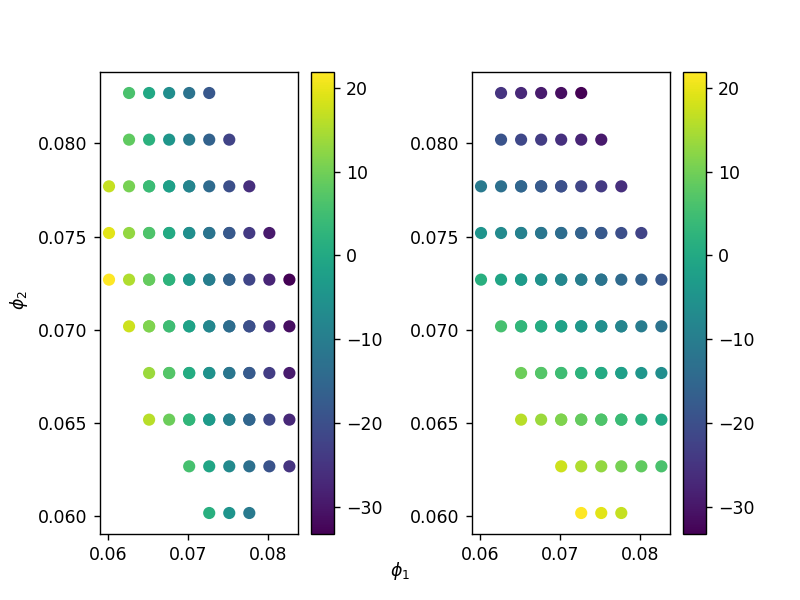

In [12]:
fig = plt.figure()
ax = fig.add_subplot(121)
fig.subplots_adjust(wspace=0.5)
path = ax.scatter(neighbors[:,0], neighbors[:,1], c=normals[:,0])
cbar = fig.colorbar(path)
ax = fig.add_subplot(122)
path = ax.scatter(neighbors[:,0], neighbors[:,1], c=normals[:,1])
cbar = fig.colorbar(path)
fig.text(0.5, 0.04, r'$\phi_1$', ha='center')
fig.text(0.01, 0.5, r'$\phi_2$', va='center', rotation='vertical')
plt.show()

In [12]:
test_epigraph = phase.TestEpiGraph(out,energy_func,phase=2,**kwargs)

<IPython.core.display.Javascript object>


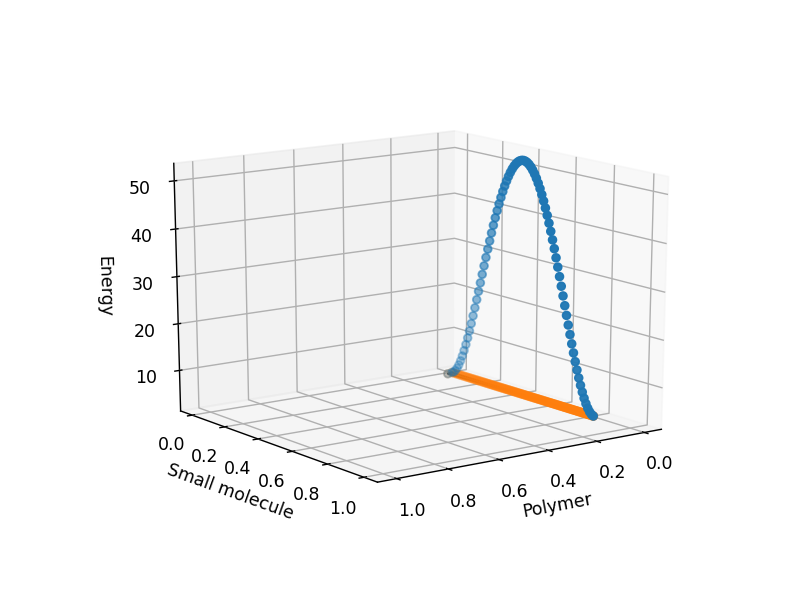

In [13]:
test_epigraph.is_epigraph()
_,ax = test_epigraph.visualize()
plt.show()

In [14]:
# check epigraph test for few random simplices
for _ in range(10):
    test = phase.TestEpiGraph(out,energy_func,phase=1,**kwargs)
    
    if test.is_epigraph():
        print('{} simplex PASSES test'.format(test.rnd_simplex))
    else:
        print('{} simplex FAILS test'.format(test.rnd_simplex))

[206 303 205] simplex PASSES test
[389 486 390] simplex PASSES test
[5031 5024 5025] simplex PASSES test
[581 582 676] simplex PASSES test
[681 587 680] simplex PASSES test
[299 201 298] simplex PASSES test
[102 201 200] simplex PASSES test
[673 672 766] simplex PASSES test
[5009 5008 4999] simplex PASSES test
[207 305 304] simplex PASSES test


<IPython.core.display.Javascript object>


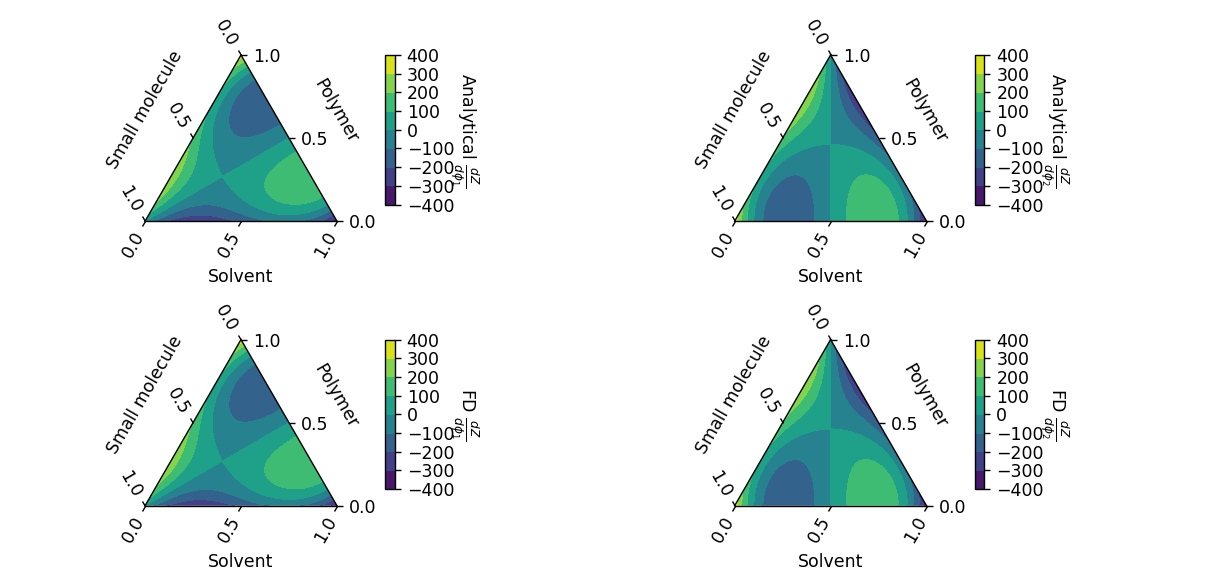

In [15]:
# Compare two gradient fields

def plot_gradient_field(grid, gradient, ax):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient)
    cax = ax.inset_axes([1.25, 0.1, 0.05, 0.9], transform=ax.transAxes)
    cbar = fig.colorbar(cs, cax=cax)
#     cbar.ax.set_yticklabels(["{:.2E}".format(i) for i in cbar.get_ticks()])
    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')

    return ax, cbar

fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.8)

grad = np.asarray([analytic_gradient(x) for x in grid.T])

ax = fig.add_subplot(2,2,1,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,2,projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,3,projection='ternary')
ax,cbar = plot_gradient_field(grid, np.nan_to_num(grad_cd[:,0]), ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,4,projection='ternary')
ax,cbar = plot_gradient_field(grid,np.nan_to_num(grad_cd[:,1]), ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


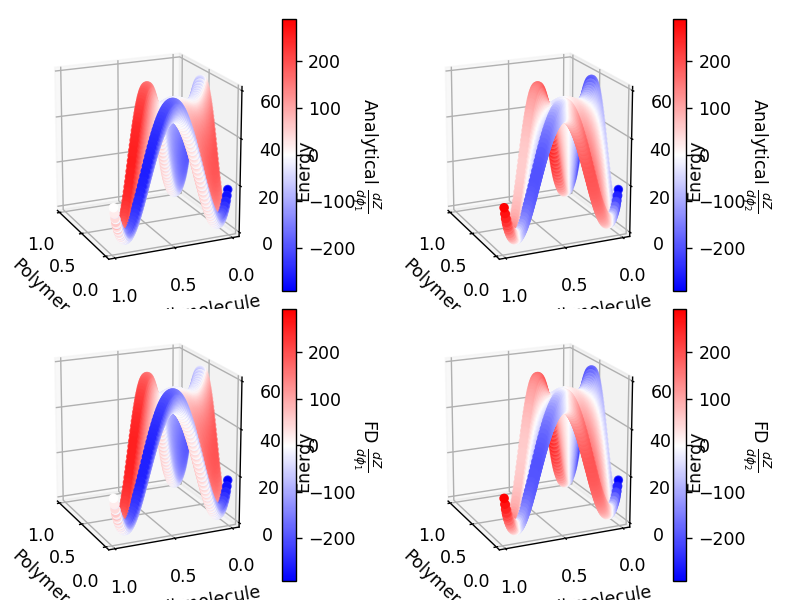

In [16]:
def plot_3d_gradient(grid,energy, grad, ax):
    boundary_points= np.asarray([phase.is_boundary_point(x) for x in grid.T])
    path = ax.scatter(grid[0,~boundary_points], grid[1,~boundary_points],
                      energy[~boundary_points], c=grad[~boundary_points],
                     cmap='bwr')
    ax.view_init(elev=16, azim=54)
    cbar = fig.colorbar(path)
    ax.set_xlabel('Polymer')
    ax.set_ylabel('Small molecule')
    ax.set_zlabel('Energy')
    ax.view_init(elev=17, azim=156)
    return ax, cbar

fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=0.8)

grad_analytic_array = np.asarray([analytic_gradient(x) for x in grid.T])
grad_cd_array = np.asarray([centraldiff_gradient(phi, h = delta) for phi in grid.T])

ax = fig.add_subplot(2,2,1,projection='3d')
ax,cbar = plot_3d_gradient(grid, energy, grad_analytic_array[:,0], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,2,projection='3d')
ax,cbar = plot_3d_gradient(grid,energy, grad_analytic_array[:,1], ax)
cbar.set_label(r'Analytical $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,3,projection='3d')
ax,cbar = plot_3d_gradient(grid,energy, grad_cd_array[:,0], ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(2,2,4,projection='3d')
ax,cbar = plot_3d_gradient(grid,energy, grad_cd_array[:,1], ax)
cbar.set_label(r'FD $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')
plt.tight_layout()
plt.show()